# UIUC Net Demand with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the net electricity demand at the University of Illinois.
All predictions in this notebook are optimized for 72 hour predictions. The
parameters will not generalize well to other prediction lengths because they
are optimized by looking at the mean squared error over the entire prediction
window.
In the future, the specific reactor design will motivate the size of the prediction
window.


The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.


The net demand prediction might be confounded by the Wind PPA. A Wind PPA means that the wind power purchased by campus is not necessarily produced near the campus. In fact, it's produced in a different county than Champaign county. So improvements to the prediction by adding weather and solar angle will be difficult if we use 

In [1]:
import platform 
operating_system = platform.system()
print(operating_system)

Linux


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
if operating_system is 'Linux':
    sys.path.insert(0, "/home/dotson/research/cairo")
elif operating_system is 'Windows':
    sys.path.insert(0, "C:/users/samgd/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [3]:
start = "11/1/2016"
end = "1/1/2019"

In [4]:
# import demand data
df_demand = pd.read_csv("data/uiuc_demand_data.csv", usecols=['time','kw'], parse_dates=True)
df_demand.time = pd.to_datetime(df_demand.time)

# mask the dates
dm_mask = (df_demand['time'] > pd.to_datetime(start)) & (df_demand['time'] < pd.to_datetime(end))
df_demand = df_demand[dm_mask]

demand = np.array(df_demand.kw).astype('float64')

# normalize
norm_d = np.linalg.norm(demand)
demand_norm = demand/norm_d

In [5]:
# import demand data
df_wind = pd.read_csv("data/railsplitter_data.csv", usecols=['Time','MWh'], parse_dates=True)
df_wind.Time = pd.to_datetime(df_wind.Time)
df_wind.MWh = df_wind.MWh*1000  # convert MWh to kWh

wd_mask = (df_wind['Time'] > pd.to_datetime(start)) & (df_wind['Time'] < pd.to_datetime(end))
df_wind = df_wind[wd_mask]
windpower = np.array(df_wind.MWh).astype('float64')

# normalize
norm_w = np.linalg.norm(windpower)
windpower_norm = windpower/norm_w

In [6]:
# import demand data
df_sun = pd.read_csv("data/solarfarm_data.csv", usecols=['time','power_data'], parse_dates=True)
df_sun.time = pd.to_datetime(df_sun.time)

sp_mask = (df_sun['time'] > pd.to_datetime(start)) & (df_sun['time'] < pd.to_datetime(end))
df_sun = df_sun[sp_mask]
solarpower = np.array(df_sun.power_data).astype('float64')

# normalize
norm_s = np.linalg.norm(solarpower)
solarpower_norm = solarpower/norm_s

In [7]:
time_range = pd.date_range(start='11/1/2016', end='1/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a

In [8]:
# Create the net demand data
net_demand = demand - solarpower - windpower
norm_n = np.linalg.norm(net_demand)
nd_norm = net_demand/norm_n

In [9]:
print(len(net_demand))
print(len(time_range))
print(len(angles_norm))

18983
18983
18983


In [10]:
# Save Net Demand Data
net_df = pd.DataFrame({'time':time_range, 'kw':net_demand})
# net_df.to_csv("data/uiuc_net_demand.csv")

### 1a. Initial demonstration

In [11]:
params = {'n_reservoir':1000, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':8000}

futureTotal = params['future']
hour_range = np.arange(0, len(time_range), 1)

In [12]:
tic = time.perf_counter()

init_pred = esn_prediction(nd_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 4.02 seconds
This simulation took 0.07 minutes


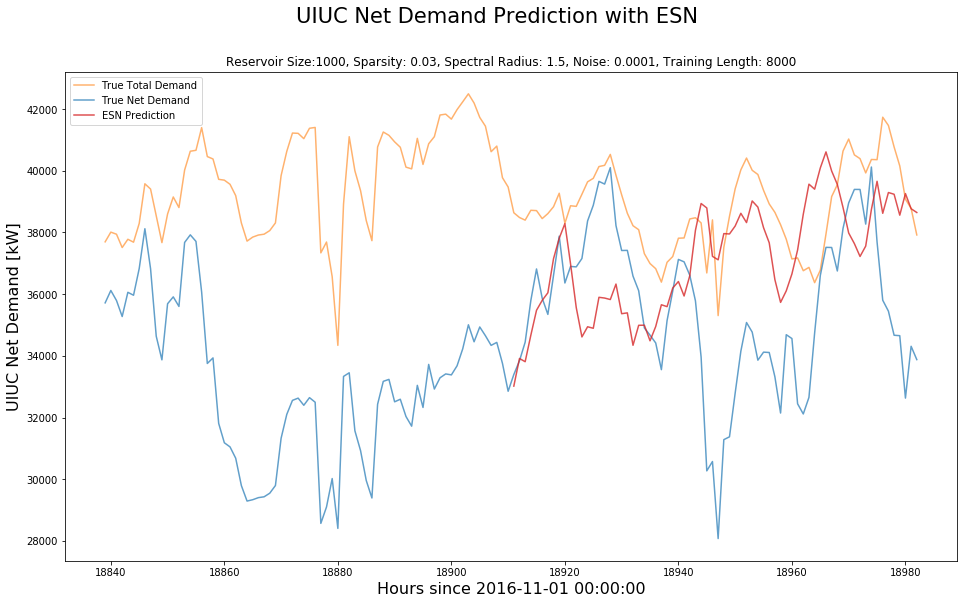

In [13]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_d*demand_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.6,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm_n*nd_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_n*init_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 1b. Initial Uncertainty Calculation

In [14]:
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

N = len(rand_seeds)
# predictions = np.ones((futureTotal, N))
predictions = []
tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(nd_norm, params)
    predictions.append(prediction)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

predictions = np.array(predictions)

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 20.56 seconds
This simulation took 0.34 minutes


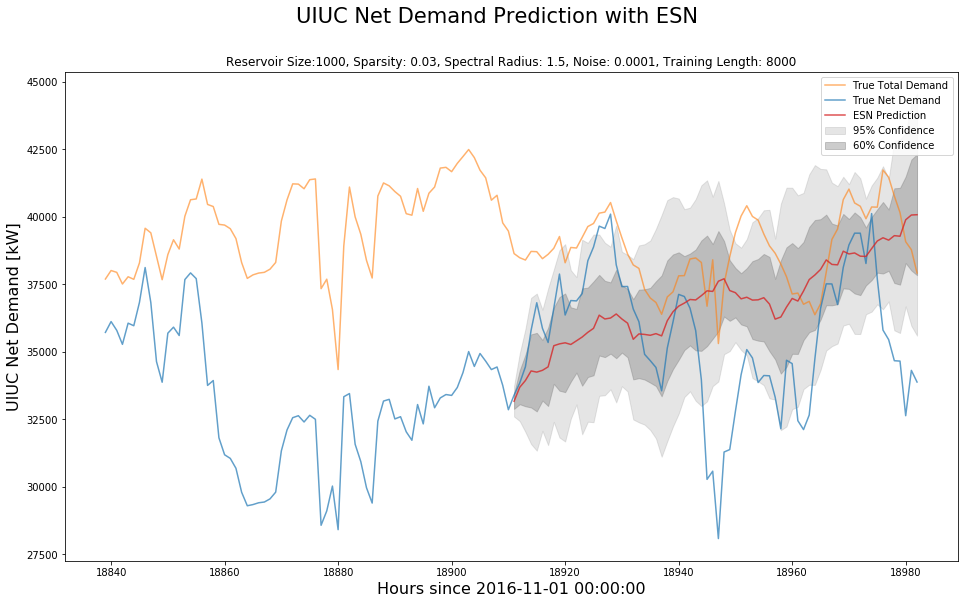

In [15]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_d*demand_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.6,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm_n*nd_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_n*mean_prediction.T[0],  alpha=0.8, 
         label='Mean ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + 2 * std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - 2 * std_prediction.T[0]),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - std_prediction.T[0]),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.0015793536768245711
rho = 0.5, noise = 0.0003, MSE=0.0016439238714199137
rho = 0.5, noise = 0.0007, MSE=0.001684253907787301
rho = 0.5, noise = 0.001, MSE=0.0016929463686611082
rho = 0.5, noise = 0.003, MSE=0.0016190367211968463
rho = 0.5, noise = 0.005, MSE=0.001534637119582957
rho = 0.5, noise = 0.007, MSE=0.0015194884675494651
rho = 0.5, noise = 0.01, MSE=0.0015921828612674757
rho = 0.7, noise = 0.0001, MSE=0.0014908697367506474
rho = 0.7, noise = 0.0003, MSE=0.0015373376128923347
rho = 0.7, noise = 0.0007, MSE=0.0015734231535981047
rho = 0.7, noise = 0.001, MSE=0.0015848140175749508
rho = 0.7, noise = 0.003, MSE=0.0015378831041648802
rho = 0.7, noise = 0.005, MSE=0.0014380851718151148
rho = 0.7, noise = 0.007, MSE=0.0013853156898319969
rho = 0.7, noise = 0.01, MSE=0.0014179153837529071
rho = 0.9, noise = 0.0001, MSE=0.0013253740642361195
rho = 0.9, noise = 0.0003, MSE=0.0014396442680619525
rho = 0.9, noise = 0.0007,

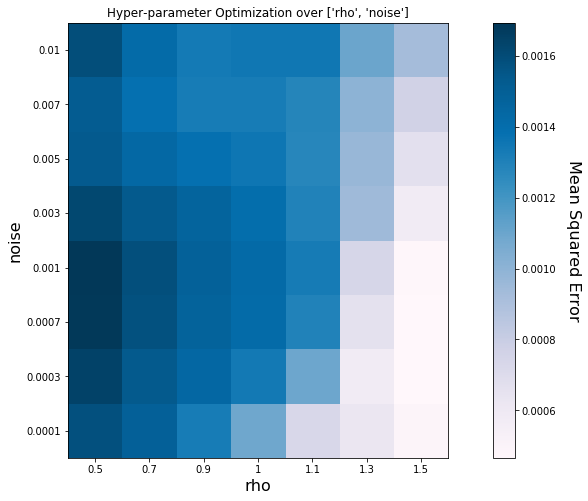

In [16]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(nd_norm,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [17]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0007


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.000464383790268214
n_reservoir = 600, sparsity = 0.01, MSE=0.0005282975284300605
n_reservoir = 600, sparsity = 0.03, MSE=0.0005252037820027536
n_reservoir = 600, sparsity = 0.05, MSE=0.0006838134829464486
n_reservoir = 600, sparsity = 0.1, MSE=0.0007461321358376209
n_reservoir = 600, sparsity = 0.15, MSE=0.0005206309750782083
n_reservoir = 600, sparsity = 0.2, MSE=0.0007348628106544037
n_reservoir = 800, sparsity = 0.005, MSE=0.0009443967753318993
n_reservoir = 800, sparsity = 0.01, MSE=0.0009285084405971795
n_reservoir = 800, sparsity = 0.03, MSE=0.0007768072972481489
n_reservoir = 800, sparsity = 0.05, MSE=0.0008834336850659137
n_reservoir = 800, sparsity = 0.1, MSE=0.0005907976584565479
n_reservoir = 800, sparsity = 0.15, MSE=0.000957611869616171
n_reservoir = 800, sparsity = 0.2, MSE=0.0010668357344301995
n_reservoir = 1000, sparsity = 0.005, MSE=0.0008028313838221945
n_reservoir = 1000, sparsit

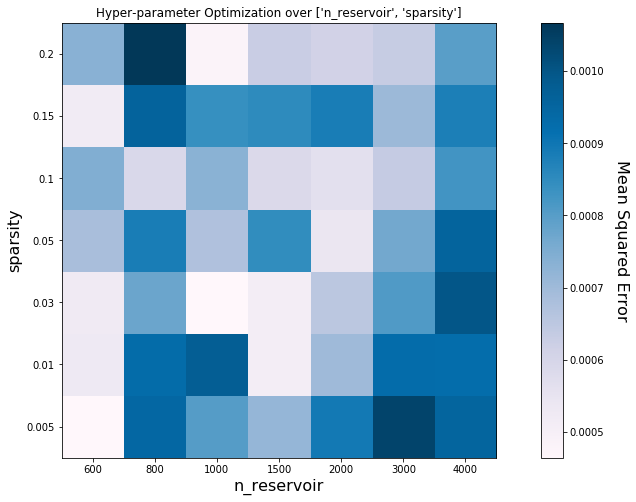

In [18]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(nd_norm,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [19]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 600 
sparsity = 0.005


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0004897357405173057
trainlen = 5300, MSE=0.0003777049716642373
trainlen = 5600, MSE=0.0006472565596801246
trainlen = 5900, MSE=0.0006015249285927061
trainlen = 6200, MSE=0.0009500664807151267
trainlen = 6500, MSE=0.0006395537732209909
trainlen = 6800, MSE=0.0010476101108468773
trainlen = 7100, MSE=0.000517559092125587
trainlen = 7400, MSE=0.00093675952563825
trainlen = 7700, MSE=0.0008883747077063911
trainlen = 8000, MSE=0.000464383790268214
trainlen = 8300, MSE=0.0005802016434797236
trainlen = 8600, MSE=0.00043382498220349895
trainlen = 8900, MSE=0.0007107015840033931
trainlen = 9200, MSE=0.0007823842915114868
trainlen = 9500, MSE=0.00046369423428469094
trainlen = 9800, MSE=0.0004141619468924169
trainlen = 10100, MSE=0.0005321271399831717
trainlen = 10400, MSE=0.00046444896038576365
trainlen = 10700, MSE=0.0006327492211270859
trainlen = 11000, MSE=0.0005013562495553848
trainlen = 11300, MSE=0.0006586504214339587
trainlen = 11600, MS

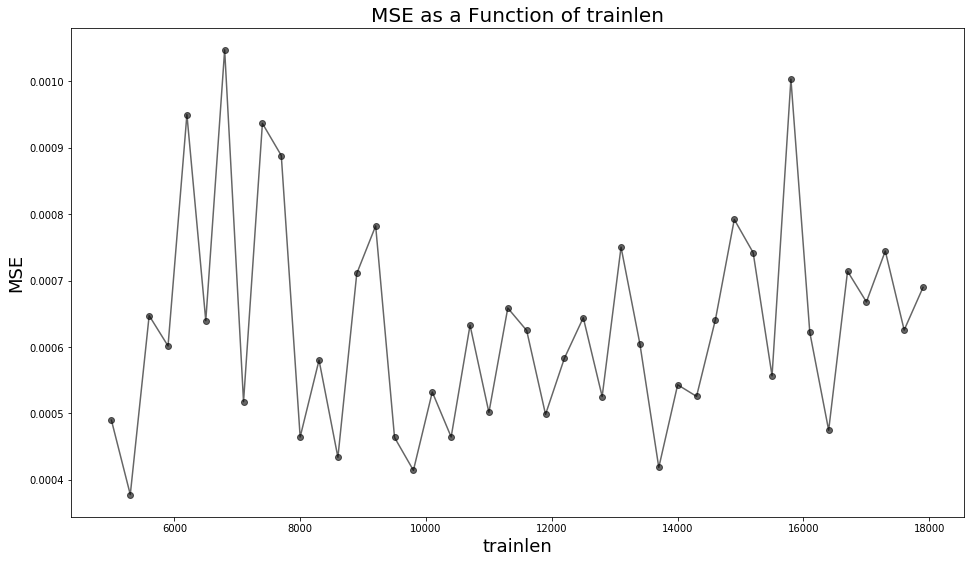

In [20]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,18000,300)
trainlen_loss = grid_optimizer(nd_norm,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [21]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 5300


### 5. Optimized Demand Prediction

In [22]:
tic = time.perf_counter()

opt_pred = esn_prediction(nd_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 0.71 seconds
This simulation took 0.01 minutes


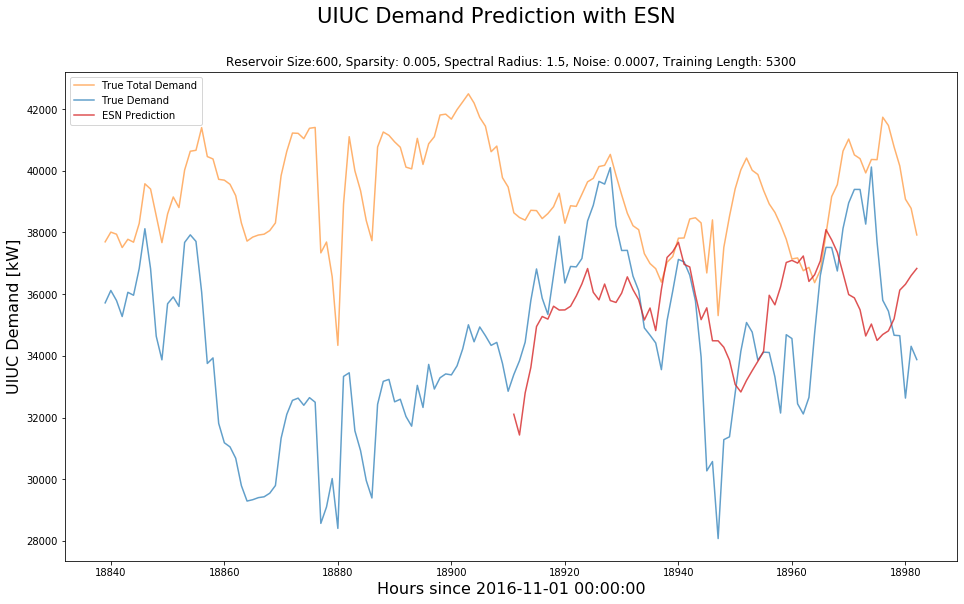

In [23]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_d*demand_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.6,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm_n*nd_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_n*opt_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 6. Uncertainty Calculation

In [24]:
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

N = len(rand_seeds)
# predictions = np.ones((futureTotal, N))
predictions = []
tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(nd_norm, params)
    predictions.append(prediction)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

predictions = np.array(predictions)

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 5.89 seconds
This simulation took 0.10 minutes


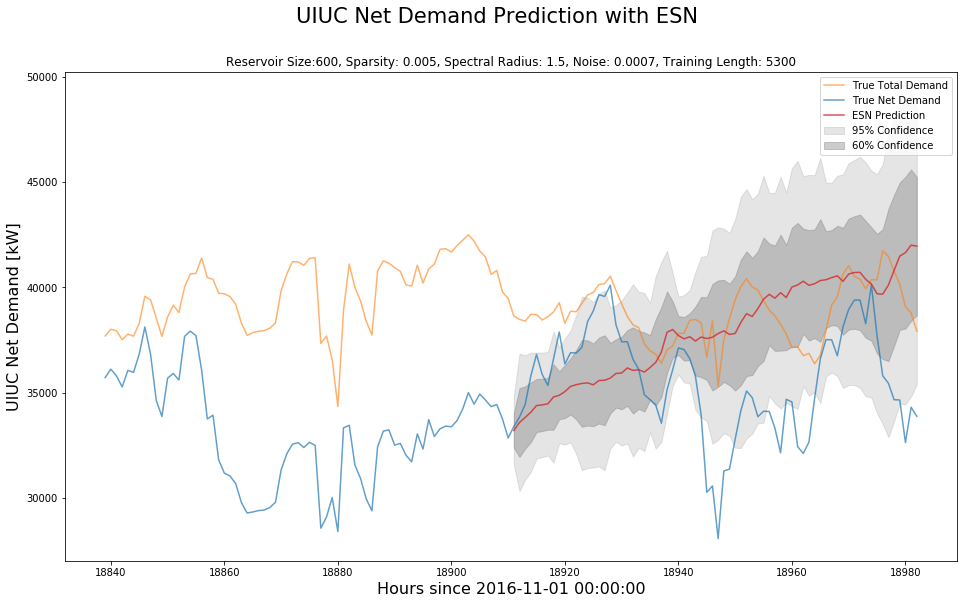

In [26]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_d*demand_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.6,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm_n*nd_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_n*mean_prediction.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + 2 * std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - 2 * std_prediction.T[0]),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - std_prediction.T[0]),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### 7. Improvement By Reducing Window Size

In [29]:
params['window'] = 36
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

N = len(rand_seeds)
# predictions = np.ones((futureTotal, N))
predictions = []
tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(nd_norm, params)
    predictions.append(prediction)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

predictions = np.array(predictions)

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 8.21 seconds
This simulation took 0.14 minutes


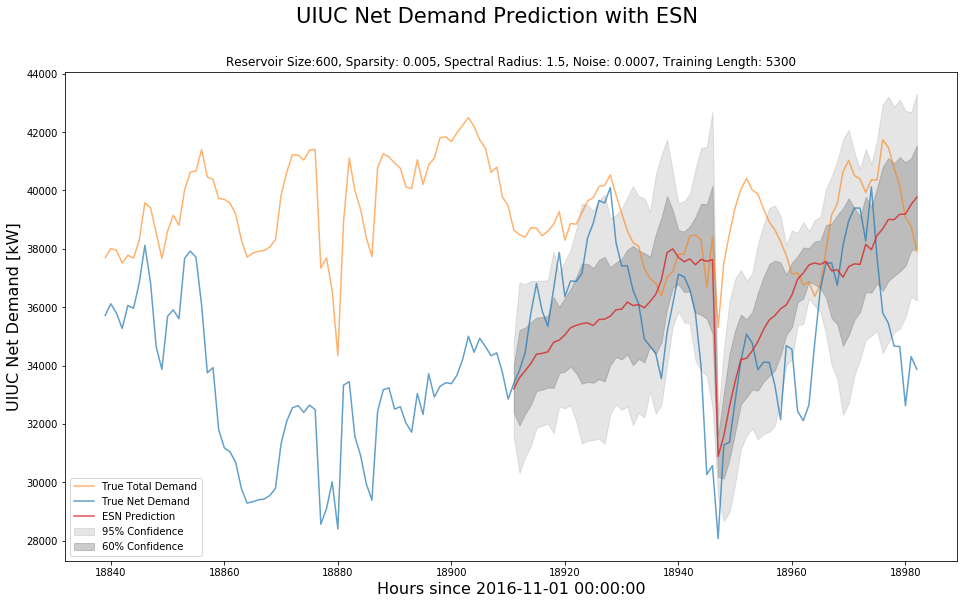

In [30]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_d*demand_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.6,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm_n*nd_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_n*mean_prediction.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + 2 * std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - 2 * std_prediction.T[0]),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm_n*(mean_prediction.T[0] + std_prediction.T[0]),
                 norm_n*(mean_prediction.T[0] - std_prediction.T[0]),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()